In [106]:
#libraries for analysis
import pandas as pd
import numpy as np

#libraries for visualisation
import seaborn as sns

#machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Data Exploration

In [72]:
#importing the train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [73]:
#identifying the shape of the data
train_data.shape

(891, 12)

In [74]:
#viewing the first 5 rows of the data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Pre-processing the data

In [75]:
#Dropping columns
train_data = train_data.drop(["Cabin", "PassengerId","Ticket","Name"], axis=1)

#Filling missing values
age_mean = train_data.Age.mean()
train_data.Age.fillna(age_mean, inplace=True)
train_data.Embarked.fillna("S", inplace=True)
    
#Categorising Age column and dropping Age column nolonger needed
train_data["AgeGroup"] = pd.cut(train_data.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
    
#Creating column to show family size of each passenger on the ship
train_data["Familysize"] = train_data["SibSp"] + train_data["Parch"]
    
#Identifying outliers and removing. Also dropping columns not needed
train_data["removed_outliers"] = train_data.Fare.between(200,550)
mask = train_data["removed_outliers"]
train_data = train_data[~mask].drop(["removed_outliers","Age","SibSp","Parch"], axis=1)

#Identifying target variable
y_train = train_data.Survived

In [76]:
train_data.head()

,Survived,Pclass,Sex,Fare,Embarked,AgeGroup,Familysize
0,0,3,male,7.2500,S,Adult,1
1,1,1,female,71.2833,C,Adult,1
2,1,3,female,7.9250,S,Adult,0
3,1,1,female,53.1000,S,Adult,1
4,0,3,male,8.0500,S,Adult,0


### One hot encoding features

In [77]:
#creating one hot encoding on select features
features_to_encode = ["Embarked","AgeGroup","Sex","Pclass"]
train_data = pd.get_dummies(train_data, columns=features_to_encode)

### Scaling the training data

In [78]:
#Apply log transform on Fares
train_data.Fare = np.log(1+train_data.Fare)

#scaling the data
scaler = StandardScaler()
scaler.fit(train_data)
X_train = scaler.transform(train_data)

In [80]:
train_data.head()

,Survived,Fare,Familysize,Embarked_C,Embarked_Q,Embarked_S,AgeGroup_Toddler/Baby,AgeGroup_Child,AgeGroup_Adult,AgeGroup_Elderly,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,2.110213,1,0,0,1,0,0,1,0,0,1,0,0,1
1,1,4.280593,1,1,0,0,0,0,1,0,1,0,1,0,0
2,1,2.188856,0,0,0,1,0,0,1,0,1,0,0,0,1
3,1,3.990834,1,0,0,1,0,0,1,0,1,0,1,0,0
4,0,2.202765,0,0,0,1,0,0,1,0,0,1,0,0,1


In [81]:
train_data.isnull().sum()

Survived                 0
Fare                     0
Familysize               0
Embarked_C               0
Embarked_Q               0
Embarked_S               0
AgeGroup_Toddler/Baby    0
AgeGroup_Child           0
AgeGroup_Adult           0
AgeGroup_Elderly         0
Sex_female               0
Sex_male                 0
Pclass_1                 0
Pclass_2                 0
Pclass_3                 0
dtype: int64

## Applying the same pre-processing on testing data

In [82]:
#Creating test data, applying the same method as previously done on the training dataset

#Dropping columns
test_data = test_data.drop(["Cabin", "PassengerId", "Ticket","Name"], axis=1)

#Filling missing values
age_mean = test_data.Age.mean()
test_data.Age.fillna(age_mean, inplace=True)
test_data.Fare.fillna(0, inplace=True) 

#Categorising Age column and dropping Age column nolonger needed
test_data["AgeGroup"] = pd.cut(test_data.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
    
#Creating column to show family size of each passenger on the ship
test_data["Familysize"] = test_data["SibSp"] + test_data["Parch"]
    
#Identifying outliers and removing. Also dropping columns not needed
test_data["removed_outliers"] = test_data.Fare.between(200,550)
mask = test_data["removed_outliers"]
test_data = test_data[~mask].drop(["removed_outliers","Age","SibSp", "Parch"], axis=1)

### one hot encoding features

In [83]:
#get dummies
features_to_encode = ["Embarked", "AgeGroup", "Sex", "Pclass"]
test_data = pd.get_dummies(test_data, columns=features_to_encode)

### Scaling the testing data

In [84]:
#Apply log transform on Fares
test_data.Fare = np.log(1 + test_data.Fare)

#scaling the data
scaler = StandardScaler()
scaler.fit(test_data)
X_test = scaler.transform(test_data)

## Extracting the predicted column and splitting the data

In [85]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Survived',axis=1), 
                                                    train_data['Survived'], 
                                                    test_size=0.2)

## Model selection

### Logistic Regression

In [86]:
#Applying Log regression 
logmodel = LogisticRegression(C=1)
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       115
           1       0.75      0.63      0.68        60

    accuracy                           0.80       175
   macro avg       0.78      0.76      0.77       175
weighted avg       0.80      0.80      0.80       175



In [89]:
print(f"The training set score is {logmodel.score(X_train, y_train)}")
print(f"The test set score is {logmodel.score(X_test, y_test)}")

The training set score is 0.7988505747126436
The test set score is 0.8


### Feature importance

In [20]:
from yellowbrick.model_selection import FeatureImportances

//anaconda3/envs/kag1/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


//anaconda3/envs/kag1/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
//anaconda3/envs/kag1/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:190: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


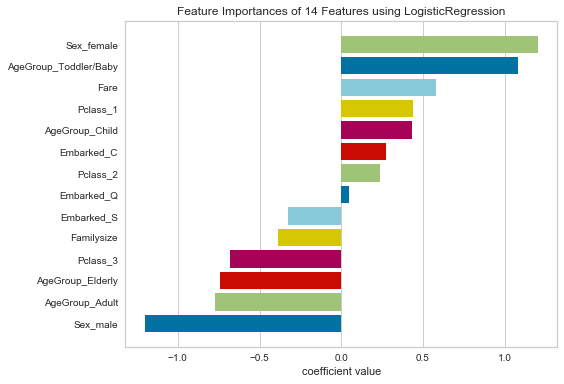

In [21]:
viz = FeatureImportances(logmodel, relative=False)
viz.fit(X_train, y_train)
viz.show()

## Decision Tree Classifier 

In [90]:
from sklearn.tree import DecisionTreeClassifier
logmodel = DecisionTreeClassifier(random_state=0)
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       115
           1       0.69      0.67      0.68        60

    accuracy                           0.78       175
   macro avg       0.76      0.76      0.76       175
weighted avg       0.78      0.78      0.78       175



### Feature importance

In [71]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(logmodel.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Sex_male,0.368
Fare,0.335
Pclass_3,0.102
Familysize,0.097
AgeGroup_Adult,0.023
AgeGroup_Toddler/Baby,0.019
Pclass_2,0.014
Embarked_S,0.010
Embarked_C,0.009


In [93]:
print(f"The training set score is {logmodel.score(X_train, y_train)}")
print(f"The test set score is {logmodel.score(X_test, y_test)}")

The training set score is 0.9367816091954023
The test set score is 0.7828571428571428


## Random Forest Classifier

In [95]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

0.8979885057471264

In [96]:
print(f"The training set score is {random_forest.score(X_train, y_train)}")
print(f"The test set score is {random_forest.score(X_test, y_test)}")

The training set score is 0.8979885057471264
The test set score is 0.8


In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       115
           1       0.70      0.72      0.71        60

    accuracy                           0.80       175
   macro avg       0.78      0.78      0.78       175
weighted avg       0.80      0.80      0.80       175



### Feature importance

In [501]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Fare,0.263
Sex_female,0.231
Sex_male,0.205
Familysize,0.081
Pclass_3,0.066
Pclass_1,0.034
AgeGroup_Toddler/Baby,0.023
Pclass_2,0.022
AgeGroup_Adult,0.021
